# Toy example

Based on https://github.com/madminer-tool/madminer/blob/main/examples/tutorial_toy_simulator/tutorial_toy_simulator.ipynb by Alexander Held, Johann Brehmer, Irina Espejo, Felix Kling, and Kyle Cranmer 2018-2019.

## Preparations

In [1]:
import os
import logging
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

from madminer.ml import ParameterizedRatioEstimator

In [2]:
if not os.path.exists("data"):
    os.makedirs("data")

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [3]:
# MadMiner output
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Toy simulator

Our simulator depends on just one parameter `theta` and produces one-dimensional observables `x`. It is characterized by one latent variable `z`. "Running" the simulator consists of two steps:
- "Hard process": a value of `z` is drawn from a normal distribution, where the mean depends on `theta`. 
- "Detector": a value for `x` is drawn from a normal distribution with mean equal to `z`. There is no explicit dependence on `theta`.

Here are some general settings (feel free to play with them): 

In [4]:
z_std = 2.0
x_std = 1.0

The following function runs the simulator for a value of `theta`:

In [5]:
def simulate(theta, npoints=None):
    # Draw latent variables z
    z = np.random.normal(loc=theta, scale=z_std, size=npoints)

    # Draw observables x
    x = np.random.normal(loc=z, scale=x_std, size=None)

    return x

Let's now visualize that: we run the simulation and plot the probability distributions $p(x | \theta_i)$. 

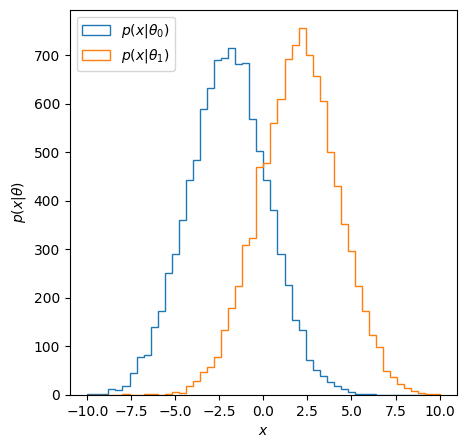

In [7]:
x0 = simulate(-2, npoints=10000)
x1 = simulate(2, npoints=10000)

xr = np.linspace(-4.0, 4.0, 100)

fig, ax1 = plt.subplots()
fig.set_size_inches(5, 5)
ax1.set_xlabel("$x$")
ax1.hist(x0, bins=50, range=(-10, 10.0), histtype="step", label=r"$p(x | \theta_0)$")
ax1.hist(x1, bins=50, range=(-10, 10.0), histtype="step", label=r"$p(x | \theta_1)$")
ax1.set_ylabel(r"$p(x|\theta)$")
ax1.legend(loc=2)

plt.show()

## 2. Run the simulation and generate training data

First, we define the parameter points we want to use for training. For this we assume that `theta` is uniformly distributed between -4 and 4. 

In [26]:
# number of parameter points to train
n_param_points = 50000

# uniform prior:
theta1 = np.random.uniform(low=-4.0, high=4.0, size=n_param_points)
theta2 = np.random.uniform(low=-4.0, high=4.0, size=n_param_points)
theta3 = np.random.uniform(low=-4.0, high=4.0, size=n_param_points)

We then run the simulator (one sample per parameter point).

In [27]:
# Sample from theta
x1_from_theta1 = simulate(theta1)
x2_from_theta2 = simulate(theta2)

Now we combine and reshape the results and save everything to files, so that we can load it later. Note that `y_train` refers to the labels, i.e. it should be 0 for points from sample A and 1 for points from sample B. Note also that we pass `theta3` instead of `theta2` for sample B.

In [28]:
# Combine results and reshape
x_train = np.hstack((x1_from_theta1, x2_from_theta2)).reshape(-1, 1)
y_train = np.hstack((np.zeros_like(x1_from_theta1), np.ones_like(np.ones_like(x2_from_theta2)))).reshape(-1, 1)
theta_train = np.hstack((theta1, theta3)).reshape(-1, 1)

# Save to file
np.save("data/theta_train.npy", theta_train)
np.save("data/x_train.npy", x_train)
np.save("data/y_train.npy", y_train)

## 3. Model training

Let's train a neural network using the CARL method introduced in ["Approximating Likelihood Ratios with Calibrated Discriminative Classifiers"](https://arxiv.org/abs/1506.02169).

In [29]:
carl = ParameterizedRatioEstimator(n_hidden=(20, 20))

carl.train(
    method="carl",
    x="data/x_train.npy",
    y="data/y_train.npy",
    theta="data/theta_train.npy",
    n_epochs=20,
)

carl.save("models/carl")

15:33 madminer.ml.paramete INFO    Starting training
15:33 madminer.ml.paramete INFO      Method:                 carl
15:33 madminer.ml.paramete INFO      Batch size:             128
15:33 madminer.ml.paramete INFO      Optimizer:              amsgrad
15:33 madminer.ml.paramete INFO      Epochs:                 20
15:33 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
15:33 madminer.ml.paramete INFO      Validation split:       0.25
15:33 madminer.ml.paramete INFO      Early stopping:         True
15:33 madminer.ml.paramete INFO      Scale inputs:           True
15:33 madminer.ml.paramete INFO      Scale parameters:       True
15:33 madminer.ml.paramete INFO      Shuffle labels          False
15:33 madminer.ml.paramete INFO      Samples:                all
15:33 madminer.ml.paramete INFO    Loading training data
15:33 madminer.utils.vario INFO      Loading data/theta_train.npy into RAM
15:33 madminer.utils.vario INFO      Loading data/x_train.

## 4. Evaluation

Let's consider a single observation:

In [30]:
x_test =  np.array([1.5])

We want to evaluate the likelihood-evidence ratio for a range of parameter points:

In [31]:
theta_grid = np.linspace(-5.0, 5.0, 100).reshape(-1, 1)
np.save("data/theta_grid.npy", theta_grid)

It's time to evaluate our likelihood ratio estimators!

In [32]:
carl = ParameterizedRatioEstimator()
carl.load("models/carl")

LER, _ = carl.evaluate(
    theta="data/theta_grid.npy",
    x=x_test,
    evaluate_score=False,
)

15:45 madminer.ml.base     INFO    Loading model from models/carl
15:45 madminer.utils.vario INFO      Loading data/theta_grid.npy into RAM


This is the LER over parameter space:

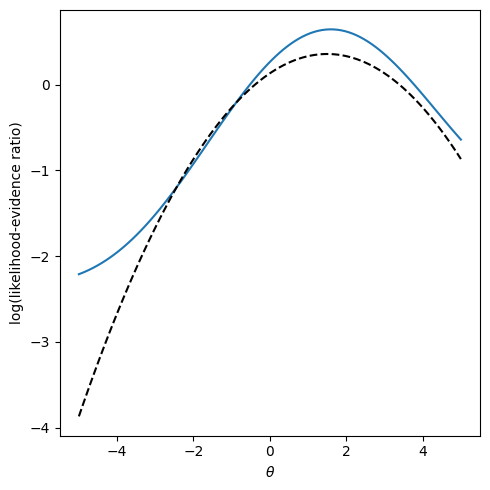

In [33]:
fig = plt.figure(figsize=(5, 5))

plt.plot(
    theta_grid,
    LER
)

plt.plot(
    theta_grid,
    np.log(8/np.sqrt(2*np.pi*(x_std**2+z_std**2)) * np.exp(-(x_test[0] - theta_grid)**2/(2 * (x_std**2+z_std**2)))),
    ls="--",
    c="black",
    label=r"True result"
)

plt.xlabel(r"$\theta$")
plt.ylabel(r"log(likelihood-evidence ratio)")

plt.tight_layout()
plt.show()